In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input

from pathlib import Path
import os.path
import matplotlib.cm as cm
import cv2
import seaborn as sns
sns.set_style('darkgrid')
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


import os
import random
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ... rest of your code ...


In [3]:
### create helper function
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
# Walk through each directory
dataset = "train"
walk_through_dir(dataset);

There are 525 directories and 0 images in 'train'.
There are 0 directories and 163 images in 'train\ABBOTTS BABBLER'.
There are 0 directories and 180 images in 'train\ABBOTTS BOOBY'.
There are 0 directories and 179 images in 'train\ABYSSINIAN GROUND HORNBILL'.
There are 0 directories and 135 images in 'train\AFRICAN CROWNED CRANE'.
There are 0 directories and 154 images in 'train\AFRICAN EMERALD CUCKOO'.
There are 0 directories and 137 images in 'train\AFRICAN FIREFINCH'.
There are 0 directories and 155 images in 'train\AFRICAN OYSTER CATCHER'.
There are 0 directories and 187 images in 'train\AFRICAN PIED HORNBILL'.
There are 0 directories and 179 images in 'train\AFRICAN PYGMY GOOSE'.
There are 0 directories and 132 images in 'train\ALBATROSS'.
There are 0 directories and 161 images in 'train\ALBERTS TOWHEE'.
There are 0 directories and 165 images in 'train\ALEXANDRINE PARAKEET'.
There are 0 directories and 166 images in 'train\ALPINE CHOUGH'.
There are 0 directories and 150 images in

In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df 


Filepath            Label
0       train\ABBOTTS BABBLER\001.jpg  ABBOTTS BABBLER
1       train\ABBOTTS BABBLER\002.jpg  ABBOTTS BABBLER
2       train\ABBOTTS BABBLER\003.jpg  ABBOTTS BABBLER
3       train\ABBOTTS BABBLER\004.jpg  ABBOTTS BABBLER
4       train\ABBOTTS BABBLER\005.jpg  ABBOTTS BABBLER
...                               ...              ...
169265        train\ZEBRA DOVE\95.jpg       ZEBRA DOVE
169266        train\ZEBRA DOVE\96.jpg       ZEBRA DOVE
169267        train\ZEBRA DOVE\97.jpg       ZEBRA DOVE
169268        train\ZEBRA DOVE\98.jpg       ZEBRA DOVE
169269        train\ZEBRA DOVE\99.jpg       ZEBRA DOVE

[169270 rows x 2 columns]

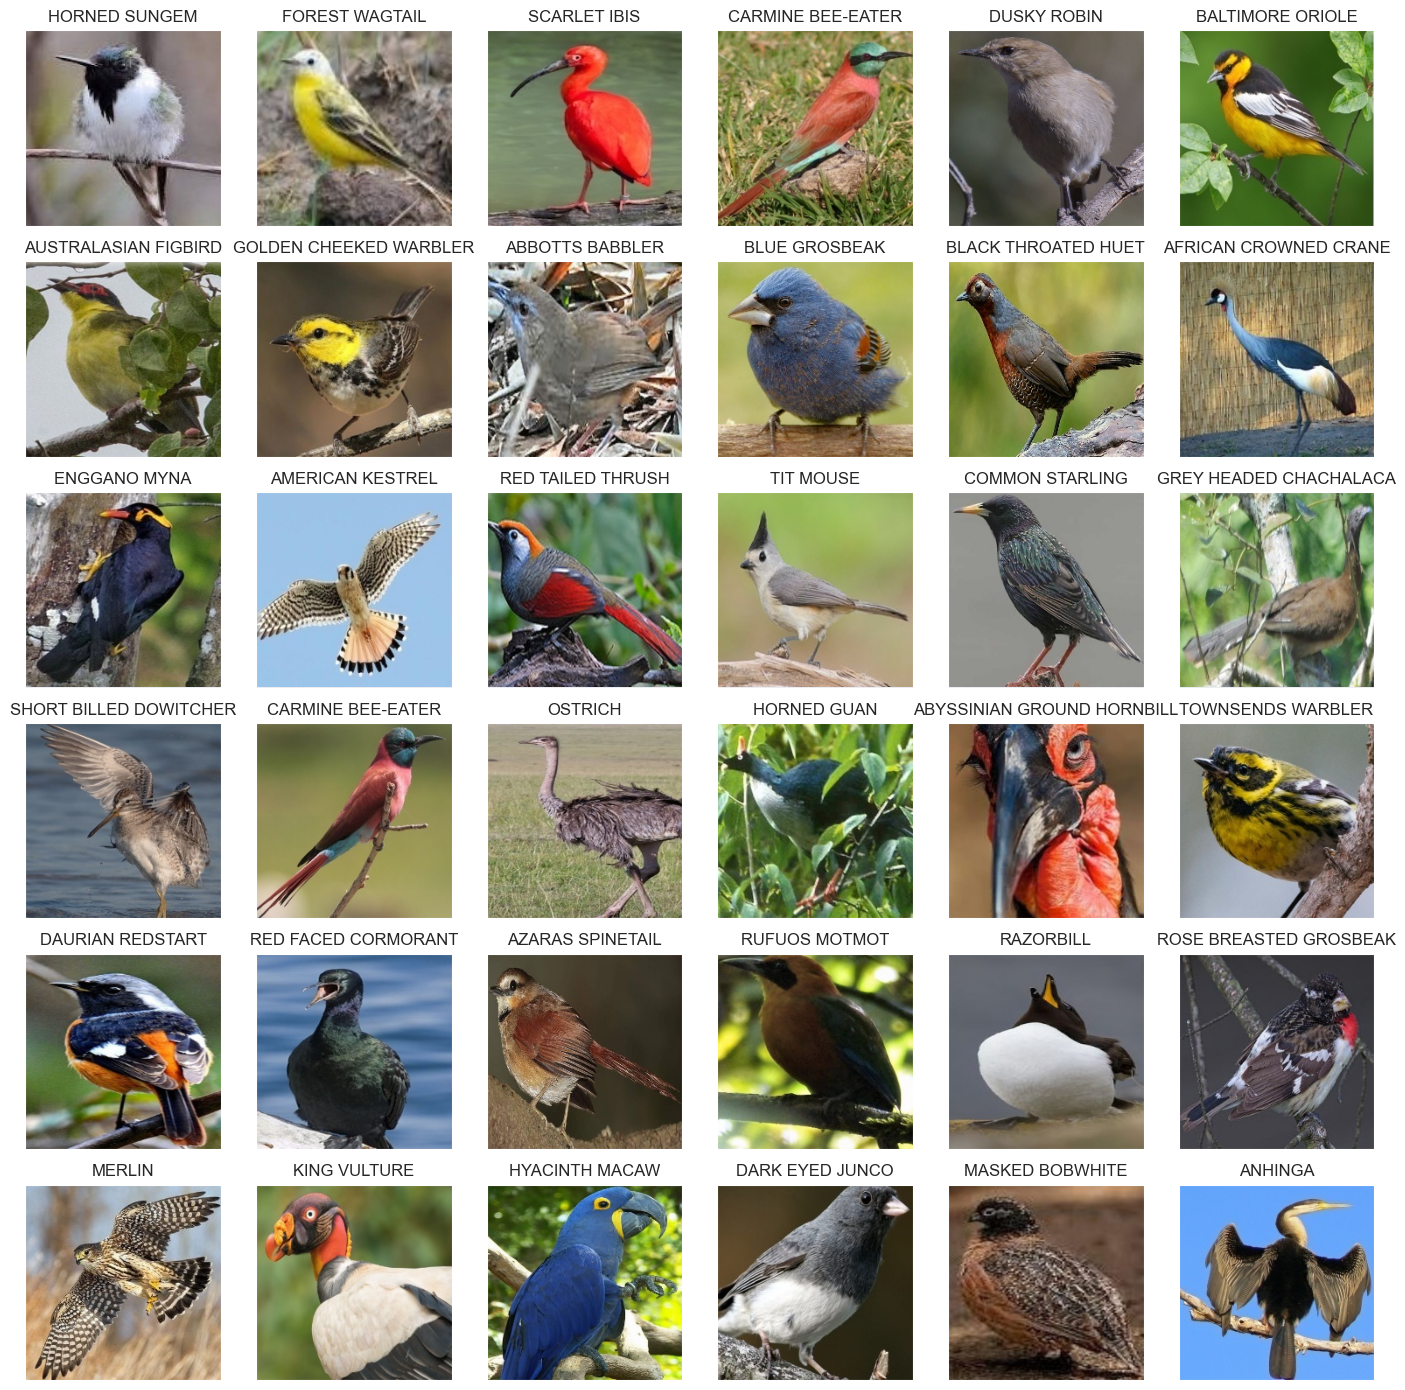

In [6]:

random_index = np.random.randint(0, len(image_df), 36)
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(14, 14),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:


# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

# Define ImageDataGenerators with ResNet50 preprocessing
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# Define data augmentation
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224, 224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)
])

# Prepare the data generators
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 108333 validated image filenames belonging to 525 classes.
Found 27083 validated image filenames belonging to 525 classes.
Found 33854 validated image filenames belonging to 525 classes.


In [8]:
# Load the pretrained model
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze the layers of the pretrained model
pretrained_model.trainable = False

# Add custom layers on top of the pretrained model
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(525, activation='softmax')(x)  # Make sure to define num_classes according to your dataset


In [9]:
# Create the model
model = Model(inputs=pretrained_model.input, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
checkpoint_path = "birds_classification_model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Now you can fit the model with your data
initial_epochs = 10
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

In [19]:
# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=initial_epochs,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

# Fine-tuning
# Unfreeze the top layers of the model
for layer in pretrained_model.layers[fine_tune_at:]:
    layer.trainable = True

# Re-compile the model (necessary for the changes to take effect)
model.compile(
    optimizer=Adam(0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_epochs = initial_epochs + fine_tune_epochs


history_fine = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=total_epochs,
    initial_epoch=history.epoch[10],
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

model.save("final_birds_classification_model.h5")


Epoch 1/10
  43/3386 [..............................] - ETA: 17:56 - loss: 2.1596 - accuracy: 0.4506

KeyboardInterrupt: 

In [28]:

model.load_weights(checkpoint_path)
initial_epoch_to_start_from = 15


history_fine = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=total_epochs,  
    initial_epoch=initial_epoch_to_start_from, 
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

model.save("final_birds_classification_model.h5")


Epoch 16/20
3386/3386 [==============================] - 1560s 461ms/step - loss: 1.3539 - accuracy: 0.6263 - val_loss: 0.5767 - val_accuracy: 0.8638 - lr: 1.0000e-04
Epoch 17/20
3386/3386 [==============================] - 1774s 524ms/step - loss: 1.3271 - accuracy: 0.6340 - val_loss: 0.5760 - val_accuracy: 0.8648 - lr: 1.0000e-04
Epoch 18/20
3386/3386 [==============================] - ETA: 0s - loss: 1.3010 - accuracy: 0.6422

KeyboardInterrupt: 

In [30]:

model.load_weights(checkpoint_path)

initial_epoch_to_start_from = 19  
history_fine = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=total_epochs,
    initial_epoch=initial_epoch_to_start_from,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)
model.save("final_birds_classification_model.h5")


Epoch 20/20
3386/3386 [==============================] - 1905s 563ms/step - loss: 1.2814 - accuracy: 0.6449 - val_loss: 0.5430 - val_accuracy: 0.8697 - lr: 1.0000e-04


In [10]:
eval_result = model.evaluate(test_images)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

1058/1058 [==============================] - 563s 529ms/step - loss: 6.3402 - accuracy: 0.0015
Test Loss: 6.340229034423828, Test Accuracy: 0.0015064689796417952


1058/1058 [==============================] - 621s 587ms/step
                               precision    recall  f1-score   support

              ABBOTTS BABBLER       0.63      0.83      0.72        65
                ABBOTTS BOOBY       0.67      0.62      0.64        71
   ABYSSINIAN GROUND HORNBILL       0.91      0.95      0.93        77
        AFRICAN CROWNED CRANE       1.00      1.00      1.00        50
       AFRICAN EMERALD CUCKOO       0.80      0.65      0.72        57
            AFRICAN FIREFINCH       0.78      0.67      0.72        54
       AFRICAN OYSTER CATCHER       0.96      0.96      0.96        69
        AFRICAN PIED HORNBILL       0.74      0.90      0.81        70
          AFRICAN PYGMY GOOSE       0.91      0.95      0.93        55
                    ALBATROSS       0.78      0.88      0.83        43
               ALBERTS TOWHEE       0.83      0.82      0.83        61
         ALEXANDRINE PARAKEET       0.95      0.95      0.95        74
               

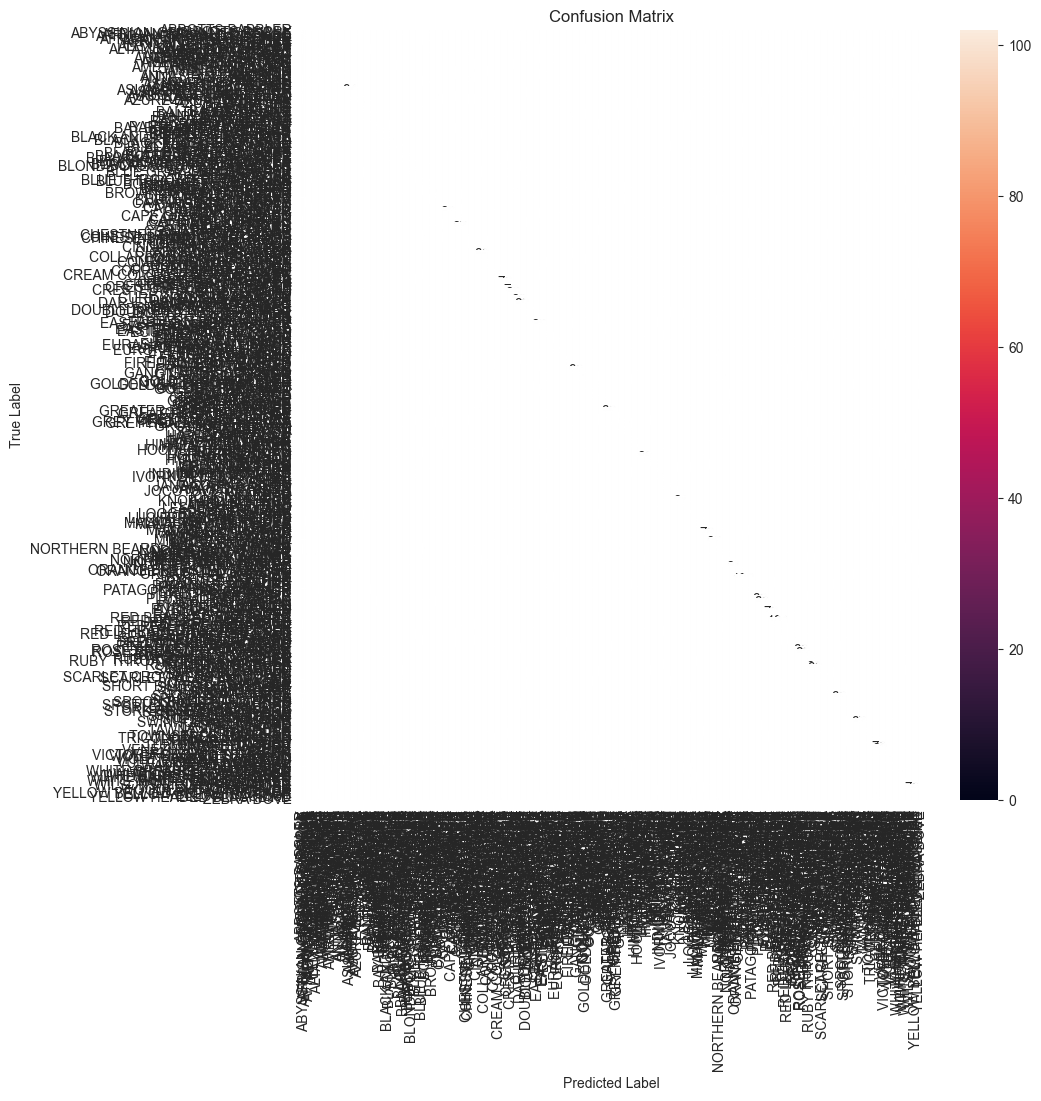

In [12]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


model = load_model("final_birds_classification_model.h5")

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_images.classes
class_labels = list(test_images.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

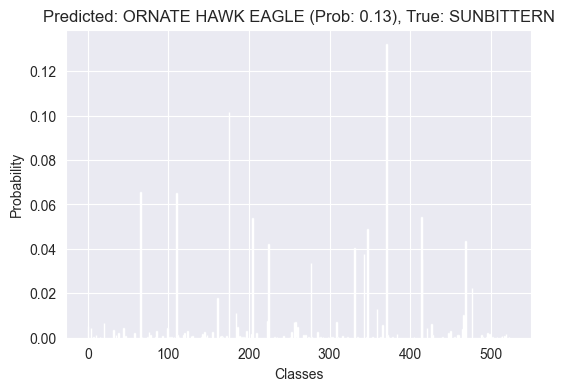

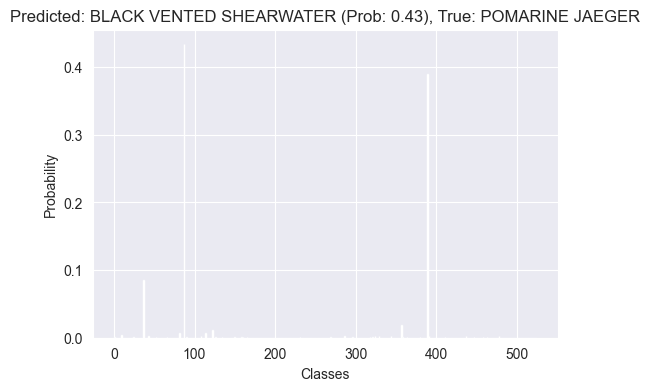

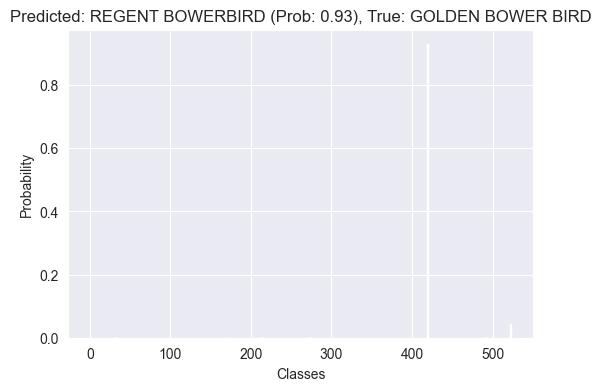

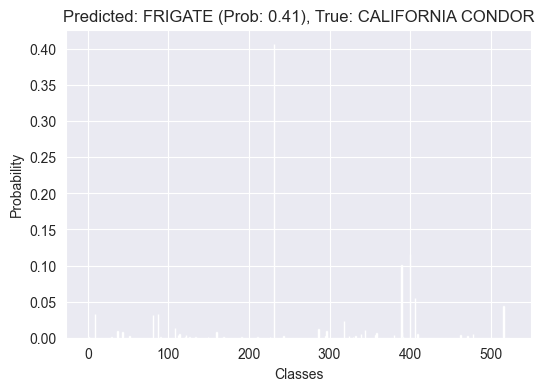

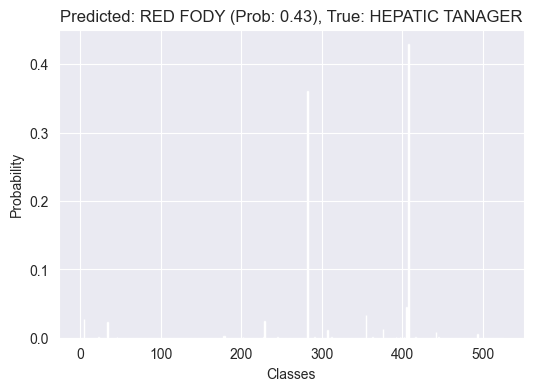

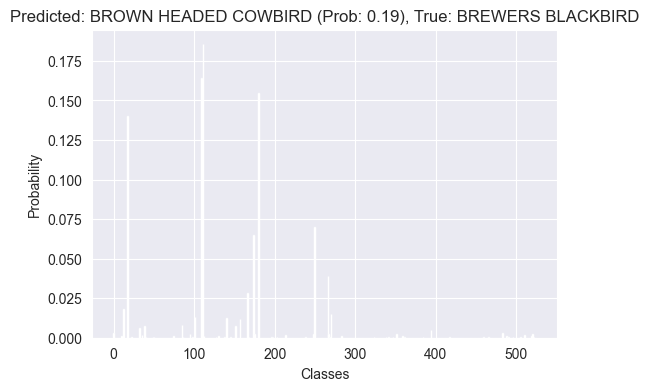

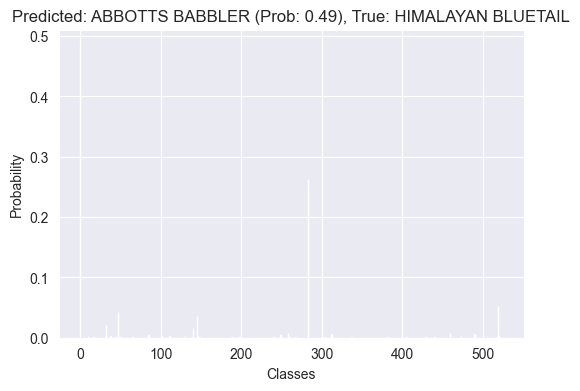

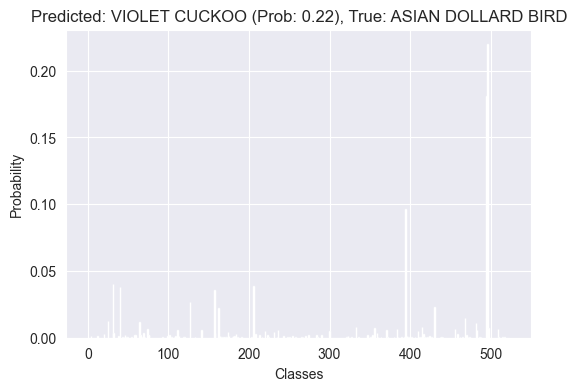

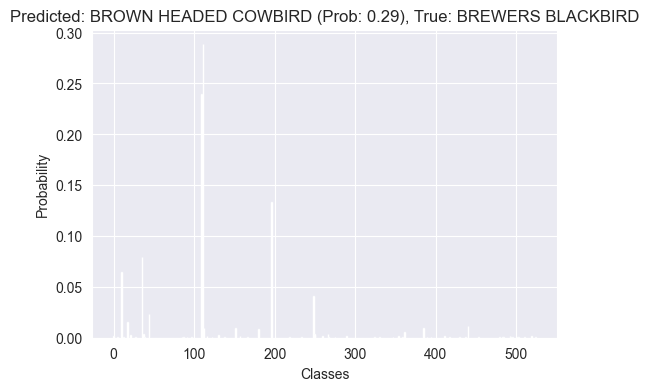

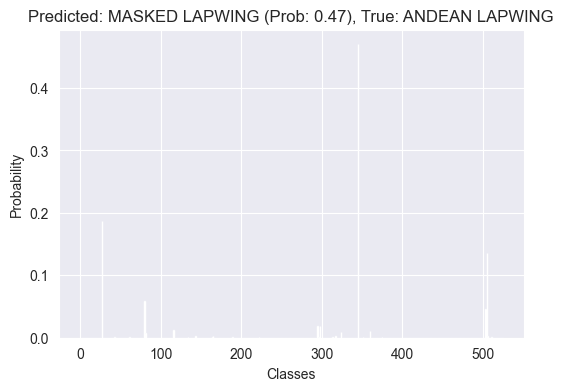

In [20]:

for i, incorrect in enumerate(incorrect_predictions[:N_to_display]):
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(class_labels)), predictions[incorrect])  
    plt.title(f"Predicted: {class_labels[predicted_classes[incorrect]]} (Prob: {np.max(predictions[incorrect]):.2f}), True: {class_labels[true_classes[incorrect]]}")
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.show()
